# Input Data Preprocessing
This Jupyter notebook contains code to process weather station data into a single .csv from multiple messy files. Once you complete this script, move to process_AWS to complete the data cleaning process.

In [99]:
import numpy as np
import os
import xarray as xr
import logging
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
logging.getLogger('matplotlib').setLevel(logging.WARNING)

## Set-up: Define variables
Fill out the cell below to set up the glacier being accessed and the filepaths.

In [100]:
# FILEPATHS
data_fp = '../climate_data/AWS/'                    # Filepath to the folder of input data
folder = data_fp + 'Raw/kaskawulsh/'                # Filepath of the folder containing the messy files
file_type = 'txt'                                   # Choose the file type (csv, txt or xlsx)

In [101]:
# Concatenate files
fn_list = os.listdir(folder)
fn_list = [f for f in fn_list if file_type in f]
col_names = ['DateTime','Pressure','Temperature','RH','Wind','Gust','Winddir','SWin','SWout','LWin','LWout']
for fn in fn_list:
    # Open the file
    df = pd.read_csv(folder + fn, index_col=0,          # Base arguments, assumes column 0 is the datetime
                            sep='\t',                   # Delimiter/separater
                            skiprows=3,                 # How many rows of metadata
                            encoding='ISO-8859-1',      # Encoding
                            engine='python',            # Engine to open the file
                            names = col_names)          # Specify the names of the columns
    
    # Get timezone
    with open(folder + fn, 'r') as f:
        lines = f.readlines()
    second_line = lines[1]
    zone_minutes = int(second_line.split('UTC')[-1].split(' ')[1])
    timezone = pd.Timedelta(minutes=zone_minutes)
    
    # Process the datetime column to be in the right format
    if len(str(df.index[0])) > 8:
        df.index = pd.to_datetime(df.index, format='%m/%d/%y %H:%M:%S') - timezone
    else:
        df.index = pd.to_datetime(df.index, format='%m/%d/%y') - timezone

    # Concatenate files
    if fn == fn_list[0]:
        df_all = df.copy(deep=True)
    else:
        df_all = pd.concat([df_all, df],axis=0)
df_all = df_all.sort_index()
df_all

,Pressure,Temperature,RH,Wind,Gust,Winddir,SWin,SWout,LWin,LWout
DateTime,,,,,,,,,,
2019-09-05 19:17:55,818.45,3.985,64.8,0.195,0.195,335.537,454.88,70.14,229.27,397.36
2019-09-05 19:30:00,818.35,4.584,61.6,0.780,2.144,339.749,478.84,79.52,231.67,405.73
2019-09-05 19:35:00,818.25,4.584,61.4,0.780,1.754,300.439,482.98,82.17,233.61,406.39
2019-09-05 19:40:00,818.45,4.740,62.3,0.974,2.534,275.169,495.79,78.50,233.16,400.72
2019-09-05 19:45:00,818.25,5.565,59.5,0.974,2.729,206.376,503.76,79.57,234.13,408.96
...,...,...,...,...,...,...,...,...,...,...
2025-07-16 08:00:00,821.55,8.120,48.2,15.436,23.154,233.051,-3.63,0.49,300.24,352.49
2025-07-16 09:00:00,821.65,7.670,51.1,15.436,22.452,238.667,-4.03,0.06,298.23,350.00
2025-07-16 10:00:00,821.55,7.895,53.5,14.734,22.452,237.263,-2.75,0.20,313.48,352.55


## Inspect data fullness

This plot can help you decide whether to process the data all together or split it into separate files (e.g., if there is a large data gap)

In [102]:
# Print data counts
df_all.count()

Pressure       52957
Temperature    52957
RH             52957
Wind           52957
Gust           52957
Winddir        52957
SWin           51151
SWout          52451
LWin           52957
LWout          52957
dtype: int64

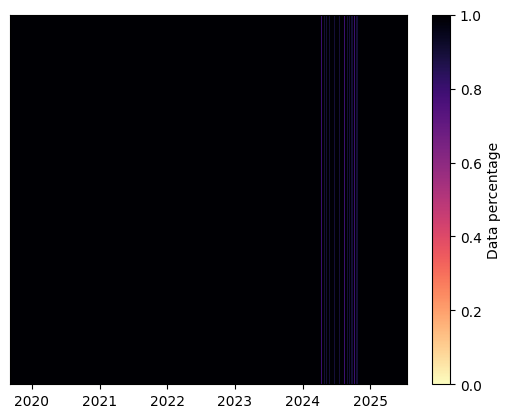

In [90]:
fig, ax = plt.subplots()
all_percentage = []
for row in df_all.index:
    percent = df_all.loc[row].count() / len(df_all.columns)
    all_percentage.append(percent)
cmap = plt.get_cmap('magma_r')
norm = mpl.colors.Normalize(vmin=0, vmax=1)
ax.bar(df_all.index, 1, pd.Timedelta(hours=1), color=cmap(norm(all_percentage)))
ax.set_xlim(df_all.index[0], df_all.index[-1])
ax.set_ylim(0,1)
ax.set_yticks([])
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Data percentage',orientation='vertical')

In [103]:
print(df_all.iloc[np.where(np.isnan(df_all['SWin']))[0][0]])

Pressure       802.850
Temperature     -8.364
RH              82.900
Wind             8.420
Gust            18.242
Winddir        299.035
SWin               NaN
SWout            0.000
LWin           189.550
LWout          263.370
Name: 2024-04-11 05:00:00, dtype: float64


In [106]:
time = pd.date_range('2019-09-05 20:00', '2024-04-10 02:00', freq='h')
# Fill random missing timestamps with Nans (will be interpolated out in processing)
for i in time:
    if i not in df_all.index:
        df_all.loc[i] = [np.nan] * len(df_all.columns)
df_all = df_all.loc[time]
print('Total n points: ',len(df_all.index))
df_all.count()

Total n points:  40279


Pressure       40266
Temperature    40266
RH             40266
Wind           40266
Gust           40266
Winddir        40266
SWin           40266
SWout          40266
LWin           40266
LWout          40266
dtype: int64

In [105]:
df_all.to_csv(folder + 'preprocessed.csv')